In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os
from functools import reduce

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
from evaluation import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [3]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [4]:
group10['title_lower'] = group10['title'].str.lower()

In [5]:
# Find relevant salt products
salt_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SALTS'))
                   |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SALT')))
                   | ((group10['item_type_name'] == 'Spices and Herbs')
                    & (group10['short_desc'].str.contains('SALT')))]

# Find relevant sugar products
sugar_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SUGAR'))
                    |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SUGAR')))
                    |((group10['item_type_name'] == 'Sugars and Sweeteners')
                    & (group10['short_desc'].str.contains('SUGAR')))]

# Find relevant water products
water_docs = group10[(group10['class_name'] == "DC BASE WATER")]

# Find relevant olive oil products
olive_oil_docs = group10[(group10['subclass_name'] == 'OLIVE OILS')
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['short_desc'].str.contains('OLIVE OIL')))
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['style_name'].str.contains('OLIVE SPRAY')))]

# Find relevant butter products
butter_docs = group10[(group10['class_name'] == 'BUTTER')]

# Find relevant milk products
milk_docs = group10[group10['class_name'] == 'MILK']

# Find relevant flour products
flour_docs = group10[(group10['class_name'] == 'SUGAR/FLOUR')
                     & (group10['subclass_name'] == 'FLOUR')]

# Find relevant all purpose flour products
all_purpose_flour_docs = group10[(group10['class_name'] == 'SUGAR/FLOUR')
                              & (group10['subclass_name'] == 'FLOUR')
                              & (group10['style_name'] == 'ALL PURPOSE FLOUR')]

# Find relevant baking powder products
baking_powder_docs = group10[(group10['class_name'] == 'BAKING NEEDS')
        & (group10['subclass_name'] == 'INGREDIENTS')
        & (group10['style_name'] == 'BAKING POWDER')]

# Find relevant egg products
egg_docs = group10[group10['item_type_name'] == 'Eggs']

# Vanilla extracts
vanilla_extract_docs = group10[group10['style_name'] == 'VANILLA EXTRACTS']

# Baking Soda
baking_soda_docs = group10[group10['style_name'] == 'BAKING SODA']

# Pepper
pepper_docs = group10[(group10['style_name'] == 'GRND BLACK PEPPER')
                      |((group10['item_type_name'] == 'Spices and Herbs')
                        & (group10['title_lower'].str.contains('black pepper')))]

# Vegetable
vegetable_oil_docs = group10[group10['style_name'] == 'VEGETABLE OIL']

# Garlic
garlic_docs = group10[group10['style_name'].isin(['MINCED GARLIC', 'GARLIC POWDER'])]

# Brown Sugar
brown_sugar_docs = group10[group10['style_name'].isin(['BROWN SUGAR'])]

# Lemon Juice
lemon_juice_docs = group10[(group10['style_name'].isin(['BULK LEMONS'])) | 
                           (((group10['item_type_name'].isin(['Juices'])) 
                           | (group10['subclass_name'].isin(['LEMONS/LIMES'])))  
                           & (group10['short_desc'].str.contains('LEMON')))]

# Lime Juice
lime_juice_docs = group10[(group10['style_name'].isin(['BULK LIMES'])) | 
                           (((group10['item_type_name'].isin(['Juices'])) 
                           | (group10['subclass_name'].isin(['LEMONS/LIMES'])))  
                           & (group10['short_desc'].str.contains('LIME')))]

# Cinnamon
cinnamon_docs = group10[(group10['style_name'].isin(['CINNAMON', 'CINNAMON STICKS']))
                       |((group10['item_type_name'] == 'Spices and Herbs')
                        & (group10['short_desc'].str.contains('CINNAMON')))]

# Honey
honey_docs = group10[group10['item_type_name'].isin(['Honey'])]

# Sour Cream
sour_cream_docs = group10[(group10['subclass_name'] == 'SOUR CREAM')]

# Soy Sauce
soy_sauce_docs = group10[(group10['item_type_name'] == 'Sauces and Marinades')
                    & (group10['short_desc'].str.contains('SOY SAUCE'))]

# Granulated Sugar
granulated_sugar_docs = group10[group10['style_name'].isin(['GRANULATED SUGAR'])]

# Cloves
cloves_docs = group10[group10['style_name'].isin(['CLOVES'])]

# Mayonnaise
mayonnaise_docs = group10[(group10['product_subtype_name'] == 'SAUCES, CONDIMENTS AND SPREADS')
                    & (group10['short_desc'].str.contains('MAYO'))]

# Get product list from docs
salt_relevant_docs = list(salt_docs['tcin'].values)
sugar_relevant_docs = list(sugar_docs['tcin'].values)
water_relevant_docs = list(water_docs['tcin'].values)
olive_oil_relevant_docs = list(olive_oil_docs['tcin'].values)
butter_relevant_docs = list(butter_docs['tcin'].values)
milk_relevant_docs = list(milk_docs['tcin'].values)
flour_relevant_docs = list(flour_docs['tcin'].values)
all_purpose_flour_relevant_docs = list(all_purpose_flour_docs['tcin'].values)
baking_powder_relevant_docs = list(baking_powder_docs['tcin'].values)
egg_relevant_docs = list(egg_docs['tcin'].values)
vanilla_extract_relevant_docs = list(vanilla_extract_docs['tcin'].values)
baking_soda_relevant_docs = list(baking_soda_docs['tcin'].values)
pepper_relevant_docs = list(pepper_docs['tcin'].values)
vegetable_oil_relevant_docs = list(vegetable_oil_docs['tcin'].values)
garlic_relevant_docs = list(garlic_docs['tcin'].values)
brown_sugar_relevant_docs = list(brown_sugar_docs['tcin'].values)
lemon_juice_relevant_docs = list(lemon_juice_docs['tcin'].values)
lime_juice_relevant_docs = list(lime_juice_docs['tcin'].values)
cinnamon_relevant_docs = list(cinnamon_docs['tcin'].values)
honey_relevant_docs = list(honey_docs['tcin'].values)
sour_cream_relevant_docs = list(sour_cream_docs['tcin'].values)
soy_sauce_relevant_docs = list(soy_sauce_docs['tcin'].values)
granulated_sugar_relevant_docs = list(granulated_sugar_docs['tcin'].values)
cloves_relevant_docs = list(cloves_docs['tcin'].values)
mayonnaise_relevant_docs = list(mayonnaise_docs['tcin'].values)


# Create ingredient and relevant products mapping
ingredient_docs_map = {}
ingredient_docs_map = dict.fromkeys(['salt', 'kosher salt'], salt_relevant_docs)
ingredient_docs_map.update(dict.fromkeys(['sugar'], sugar_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['water'], water_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['olive oil'], olive_oil_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['butter'], butter_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['milk'], milk_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['flour'], flour_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['all purpose flour', 'all-purpose flour'], all_purpose_flour_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['baking powder'], baking_powder_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['egg', 'eggs', 'large eggs'], egg_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['vanilla extract', 'vanilla'], vanilla_extract_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['baking soda'], baking_soda_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['pepper', 'black pepper'], pepper_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['vegetable oil'], vegetable_oil_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['garlic'], garlic_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['brown sugar'], brown_sugar_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['lemon juice', 'fresh lemon juice'], lemon_juice_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['lime juice', 'fresh lime juice'], lime_juice_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['cinnamon', 'ground cinnamon'], cinnamon_relevant_docs))       
ingredient_docs_map.update(dict.fromkeys(['salt and pepper'], salt_relevant_docs + pepper_relevant_docs))    
ingredient_docs_map.update(dict.fromkeys(['honey'], honey_relevant_docs))                           
ingredient_docs_map.update(dict.fromkeys(['sour cream'], sour_cream_relevant_docs))                           
ingredient_docs_map.update(dict.fromkeys(['soy sauce'], soy_sauce_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['granulated sugar'], granulated_sugar_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['cloves, minced', 'cloves'], cloves_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['mayonnaise'], mayonnaise_relevant_docs))                                       

In [6]:
import pickle
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

In [7]:
# Get rankings for multiple ingredients
ingredients = ingredient_docs_map.keys()
relevant_docs_list = ingredient_docs_map.values()
k=20

In [8]:
# Get embeddings for Sentence Transformers 
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
all_matches = group10['title_lower'].values

In [9]:
multi_lm_embeddings = get_embeddings('data/hier_embeddings.pkl')

In [10]:
pm = Mapper(group10)
clf_name_class_name = '/Users/mvellera/data/practicum/models/nli-classification-class_name'
clf_name_item_type_name = '/Users/mvellera/data/practicum/models/nli-classification-item_type_name'
clf_name_subclass_name = '/Users/mvellera/data/practicum/models/nli-classification-subclass_name'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [17]:
# Bi encoder
multi_lm = TransformerRanker(model=multi_lm_embedder, product_ids=group10['tcin'], max_rank=k)
multi_lm.load_embeddings(multi_lm_embeddings)

# Bi encoder with classifier
multi_lm_clf = TransformerRanker(model=multi_lm_embedder, product_ids=group10['tcin'],
                             max_rank=k, clf=[clf_class_name, 
                                              clf_item_type_name,
                                              clf_subclass_name])
multi_lm_clf.load_embeddings(multi_lm_embeddings)

# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
# cross_encoder_model = base_clf_item_type_name
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)

# Cross encoder with classifier
cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)                        

In [18]:
multi_lm_ranker_lists = multi_lm.rank_products_recipe(ingredients)
multi_lm_clf_ranker_lists = multi_lm_clf.rank_products_recipe(ingredients)

Filtered salt for class_name: SPICES
Filtered kosher salt salt for class_name: SPICES
Filtered olive oil for class_name: SHORTENING/OIL
Filtered olive oil for item_type_name: Cooking and Dipping Oils
Filtered milk for class_name: MILK
Filtered all purpose flour flour for class_name: SUGAR/FLOUR
Filtered all purpose flour flour for subclass_name: FLOUR
Filtered all-purpose flour flour for class_name: SUGAR/FLOUR
Filtered all-purpose flour flour for subclass_name: FLOUR
Filtered eggs for class_name: EGGS
Filtered large eggs eggs for class_name: EGGS
Filtered baking soda soda for class_name: BAKING NEEDS
Filtered vegetable oil for class_name: SHORTENING/OIL
Filtered vegetable oil for subclass_name: VEGETABLE OIL
Filtered brown sugar sugar for class_name: SUGAR/FLOUR
Filtered brown sugar sugar for subclass_name: SUGAR
Filtered sour cream cream for class_name: CULTURED PRODUCTS
Filtered soy sauce for class_name: ASIAN
Filtered granulated sugar sugar for class_name: SUGAR/FLOUR
Filtered gran

In [19]:
cr_multi_lm_ranker_lists = cr_multi_lm.rank_products_recipe(ingredients)
cr_multi_lm_clf_ranker_lists = cr_multi_lm_clf.rank_products_recipe(ingredients)

Filtered salt for class_name: SPICES
Filtered kosher salt salt for class_name: SPICES
Filtered olive oil for class_name: SHORTENING/OIL
Filtered olive oil for item_type_name: Cooking and Dipping Oils
Filtered milk for class_name: MILK
Filtered all purpose flour flour for class_name: SUGAR/FLOUR
Filtered all purpose flour flour for subclass_name: FLOUR
Filtered all-purpose flour flour for class_name: SUGAR/FLOUR
Filtered all-purpose flour flour for subclass_name: FLOUR
Filtered eggs for class_name: EGGS
Filtered large eggs eggs for class_name: EGGS
Filtered baking soda soda for class_name: BAKING NEEDS
Filtered vegetable oil for class_name: SHORTENING/OIL
Filtered vegetable oil for subclass_name: VEGETABLE OIL
Filtered brown sugar sugar for class_name: SUGAR/FLOUR
Filtered brown sugar sugar for subclass_name: SUGAR
Filtered sour cream cream for class_name: CULTURED PRODUCTS
Filtered soy sauce for class_name: ASIAN
Filtered granulated sugar sugar for class_name: SUGAR/FLOUR
Filtered gran

In [20]:
print('Sentence Transformers (L1 Ranker):')
# Multi LM rankings
multi_lm_map, multi_lm_ap = mean_average_precision(multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM MAP: {multi_lm_map:.2f}')

# Multi LM CLF rankings
multi_lm_clf_map, multi_lm_clf_ap = mean_average_precision(multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM CLF MAP: {multi_lm_clf_map:.2f}')

print('\nSentence Transformers (L2 Ranker):')
# CR Multi LM rankings
cr_multi_lm_map, cr_multi_lm_ap = mean_average_precision(cr_multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM  MAP: {cr_multi_lm_map:.2f}')

# CR Multi LM CLF rankings
cr_multi_lm_clf_map, cr_multi_lm_clf_ap = mean_average_precision(cr_multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM CLF MAP: {cr_multi_lm_clf_map:.2f}')

Sentence Transformers (L1 Ranker):
Multi LM MAP: 0.91
Multi LM CLF MAP: 0.91

Sentence Transformers (L2 Ranker):
CR Multi LM  MAP: 0.94
CR Multi LM CLF MAP: 0.94


In [15]:
# Compare APs at ingredient level
dfs = [create_ap_df(ingredients, multi_lm_ap, 'multi_lm_ap'),
       create_ap_df(ingredients, multi_lm_clf_ap, 'multi_lm_clf_ap'),
       create_ap_df(ingredients, cr_multi_lm_ap, 'cr_multi_lm_ap'),
       create_ap_df(ingredients, cr_multi_lm_clf_ap, 'cr_multi_lm_clf_ap')]
df_final = reduce(lambda left, right: pd.merge(left, right, on='ingredient'), dfs)

pd.options.display.float_format = '{:,.1f}'.format
df_final

,ingredient,multi_lm_ap,multi_lm_clf_ap,cr_multi_lm_ap,cr_multi_lm_clf_ap
0,salt,1.0,1.0,1.0,1.0
1,kosher salt,1.0,1.0,0.8,1.0
2,sugar,0.9,0.9,1.0,1.0
3,water,0.4,0.4,0.4,0.4
4,olive oil,1.0,1.0,1.0,1.0
5,butter,0.9,0.9,1.0,1.0
6,milk,1.0,1.0,1.0,1.0
7,flour,1.0,1.0,1.0,1.0
8,all purpose flour,1.0,1.0,1.0,1.0
9,all-purpose flour,1.0,1.0,1.0,1.0


spanish onion
[51586655, 14917313, 13474244, 14917361, 51743387, 15414792, 14916870, 77789463, 79643222, 47085488]


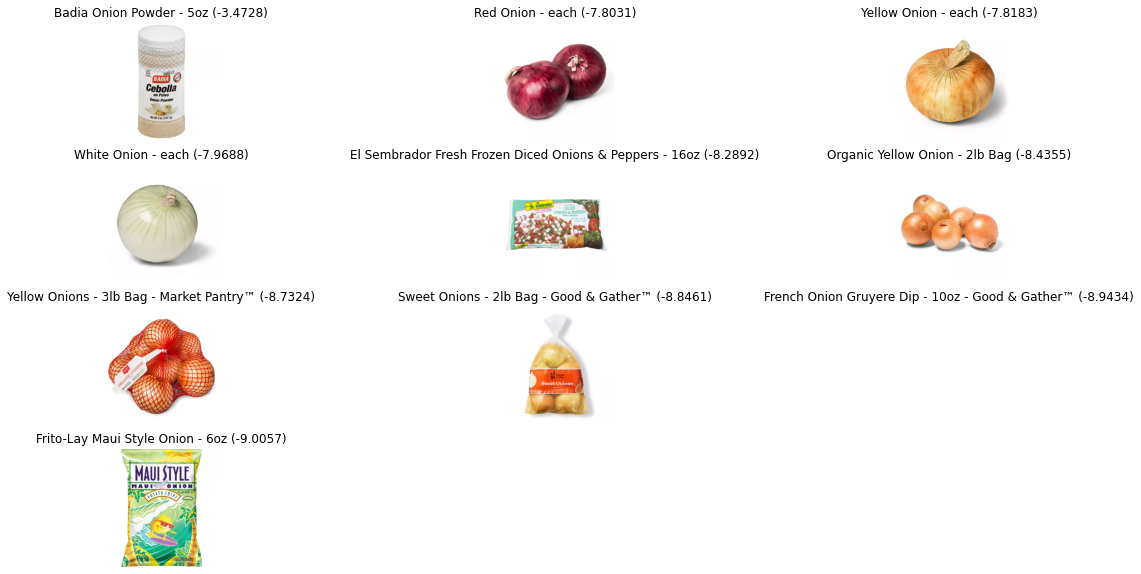

In [21]:
dp = DisplayProducts(ranker=cr_multi_lm_clf, mapper=pm)
dp.display_products_ingredient('spanish onion', 10)

In [17]:
group10[group10['tcin'] == 78825236]['title'].values

array(['Smartwater Watermelon Mint Enhanced Water - 23.7 fl oz Water'],
      dtype=object)

In [35]:
import torch
ingredient = 'spanish onion'
clf = clf_subclass_name
scores = clf.predict([ingredient])
scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()
n = 10
labels = [(clf.le.encoder[score_argmax], score_max)
    for score_argmax, score_max 
    in zip(scores.argsort()[-n:][::-1], sorted(scores, reverse=True)[0:n])]
labels

[('GARLIC/ONION', 0.34208602),
 ('OTHER', 0.11507391),
 ('MAIN VEG', 0.06449268),
 ('BLENDS', 0.05162976),
 ('BAG STEAM', 0.034313466),
 ('CANNED VEGETABLES', 0.03101053),
 ('BAG NO STEAM', 0.030078202),
 ('1LB', 0.029014388),
 ('CORE H&S', 0.027469603),
 ('HISPANIC SEASONING', 0.023286374)]

In [36]:
group10[group10['tcin'] == 13170448][['tcin', 'title', 'class_name', 'subclass_name', 'item_type_name', 'style_name']]

,tcin,title,class_name,subclass_name,item_type_name,style_name
160,13170448,Morton Coarse Kosher Salt - 16oz.,SPICES,SALTS,Spices and Herbs,SALT


In [38]:
# # Precision-Recall Plot for multiple ingredients
# lm_avg_precision_list = avg_precision_till(k, lm_ranker_lists, relevant_docs_list)
# lm_avg_recall_list = avg_recall_till(k, lm_ranker_lists, relevant_docs_list)
# glove_avg_precision_list = avg_precision_till(k, glove_ranker_lists, relevant_docs_list)
# glove_avg_recall_list = avg_recall_till(k, glove_ranker_lists, relevant_docs_list)
# ranks = list(range(1, 101, 1))

# fig, ax = plt.subplots(figsize=(16, 4))
# ax.plot(lm_avg_recall_list, lm_avg_precision_list, label='LM')
# ax.plot(glove_avg_recall_list, glove_avg_precision_list, label='Glove')
# plt.legend()
# plt.show()